\begin{equation}
 \left\{\begin{array}{ll}
 P' = - P (t) + 2 N(t) P (t),   \hskip 3mm t \in [ 0, 10],\\[10pt]
 N' = 5 N (t) - 3 N(t) P (t), \\[10pt]
  \ P(0) = 2, \hskip 3mm N(0) = 0.5,
 \end{array} \right.
 \end{equation}

# 1. Librerias

In [1]:
# Importar librerias
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.autograd as grad
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
import math
#from pyDOE import lhs         #Latin Hypercube Sampling

# 2. Presa Depredador

In [2]:
def presaDepredador(r,t):

  """
  r : es una matriz que contiene las variables dependientes
  t : vector de las variables independientes

  """

  y1 = r[0]
  y2 = r[1]

  dy1dt = -y1 + 2*y1*y2
  dy2dt = 5*y2 -3*y1*y2
  return np.array([dy1dt,dy2dt], float)

In [3]:
N=1000
Nf = 1000 # puntos para evaluar el residuo
print_freq = 2000 # imprimir cada epoca

# We integrate between tMin and tMax .............
t0,tf = 0.0,3

y10,y20 = 2.0,0.5
y0 = np.array([y10,y20], float)

In [4]:
t = torch.linspace(t0,tf,N)

In [5]:
y0 = [y10,y20]
sol = odeint(presaDepredador,y0,t) # lo resuelve por columnas
sol

array([[2.        , 0.5       ],
       [1.999991  , 0.49850077],
       [1.99996401, 0.49700612],
       ...,
       [1.97636837, 0.42806217],
       [1.97550761, 0.42687119],
       [1.97463307, 0.42568677]])

In [6]:
t = t.view(-1,1)
t.shape

torch.Size([1000, 1])

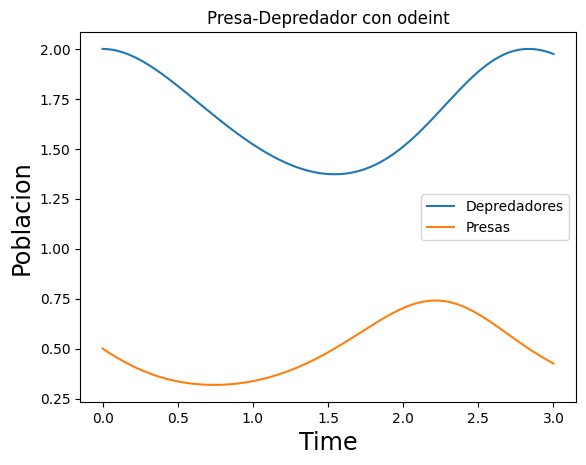

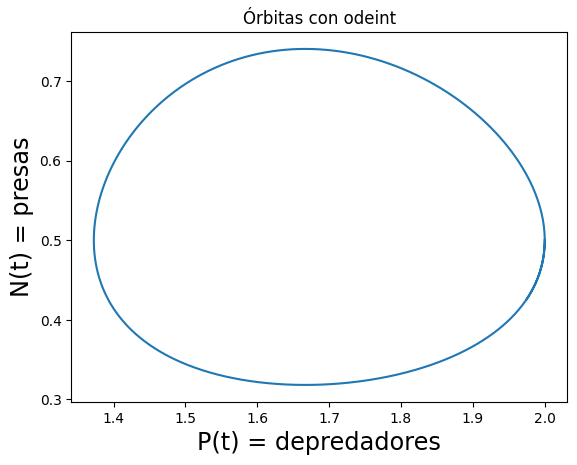

In [7]:
# representacion de la solucion
fig3 = plt.figure(3)
plt.plot(t, sol[:,0], label = "Depredadores")
plt.plot(t, sol[:,1], label = "Presas")
plt.xlabel("t")
plt.ylabel("Poblacion")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("Poblacion",fontsize="xx-large")
plt.legend()
plt.title("Presa-Depredador con odeint")
plt.show()


# espacio de fases
fig4 = plt.figure(4)
plt.plot(sol[:,0], sol[:,1])
plt.xlabel("P(t) = depredadores",fontsize="xx-large")
plt.ylabel("N(t) = presas",fontsize="xx-large")
plt.title("Órbitas con odeint")
plt.show()

# 3. Entrenamiento

In [8]:
# Fijamos la semilla
torch.manual_seed(1234)
np.random.seed(1234)

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [10]:
class PINN(nn.Module):     # definir la clase (al heredar de nn.Module clase PINN
                           # tiene acceso a muchas utilidades y métodos proporcionados por PyTorch
                           # para el entrenamiento y la evaluación de modelos

    def __init__(self, input_size, hidden_size, output_size):    # Inicializador
                           # llamamos al inicializador de la clase base nn.Module mediante super()
                           # Esto asegura que todas las funcionalidades de nn.Module se inicialicen correctamente
        super(PINN, self).__init__()

        # Definir las capas de la red neuronal (aqui 3 capas lineales: nn.Linear)
        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Una capa lineal significa que salida = Entradas×Pesos + Sesgo

        # Capa 1: Entrada con input_size características, salida con hidden_size características
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        # Capa 3: Entrada con hidden_size características, salida con 1 característica
        self.fc4 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos (I): Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # Inicialización de pesos (II): Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica o la función logística (sigmoid).
        # Ayuda a mantener una varianza constante a través de las capas
        ## Sale mejor en este ejemplo que sin dicha inicializacion
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc5.weight)
        nn.init.xavier_normal_(self.fc6.weight)
        nn.init.xavier_normal_(self.fc4.weight)


        # Inicialización de pesos (III): He Initialization: Similar a la inicialización de Xavier,
        # pero ajustada para su uso con funciones de activación ReLU (Rectified Linear Unit).
        #nn.init.kaiming_normal_(model.fc1.weight)
        #nn.init.kaiming_normal_(model.fc2.weight)
        #nn.init.kaiming_normal_(model.fc3.weight)

        # Inicialización de pesos (IV):  LeCun Initialization:
        # Inicialización propuesta por LeCun para funciones de activación como la tangente hiperbólica
        # nn.init.normal_(layer.weight, mean=0, std=np.sqrt(1 / layer.weight.shape[0]))
        # init.normal_(self.fc1.weight, mean=0, std=np.sqrt(1 / self.fc1.weight.shape[0]))
        # init.normal_(self.fc2.weight, mean=0, std=np.sqrt(1 / self.fc2.weight.shape[0]))
        # init.normal_(self.fc3.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))

        # Inicializacion de las bias
        nn.init.zeros_(self.fc1.bias.data)
        nn.init.zeros_(self.fc2.bias.data)
        nn.init.zeros_(self.fc3.bias.data)
        nn.init.zeros_(self.fc5.bias.data)
        nn.init.zeros_(self.fc6.bias.data)
        nn.init.zeros_(self.fc4.bias.data)

    def forward(self, x):
       # Define la operación hacia adelante de la red neuronal, i.e cómo se realiza la operación hacia adelante en la red neuronal.
       # Se aplican funciones de activación tangente hiperbólica (torch.tanh) después de cada capa lineal
       # En este caso, el método forward toma la entrada x y la pasa a través de las capas fc1, fc2 y fc3
       # utilizando la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas.
       # La última capa (fc3) no tiene una función de activación
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = torch.tanh(self.fc3(x))
       x = torch.tanh(self.fc5(x))
       x = torch.tanh(self.fc6(x))
       x = self.fc4(x)           # No aplicamos función de activación en la última capa fc3

       # Aplicacion a la sigmoide
       #x = torch.sigmoid(self.fc1(x))
       #x = torch.sigmoid(self.fc2(x))
       #x = self.fc3(x)

       return x

In [11]:
# Función para calcular la derivada
def compute_derivative(model, x):
    g = x.clone()
    g.requires_grad_(True)         # Activar el flag requires_grad para que se realice el seguimiento de gradientes
    y_pred = model(g)# Obtener las predicciones del modelo para las entradas
    p=y_pred[:,0].view(2000,1)
    n=y_pred[:,1].view(2000,1)
    p_t = torch.autograd.grad(p, g, grad_outputs=torch.ones_like(p), retain_graph = True, create_graph=True)[0]
    n_t = torch.autograd.grad(n, g, grad_outputs=torch.ones_like(n), retain_graph = True, create_graph=True)[0]
    return p,n,p_t, n_t

# Función para calcular la condición inicial
def initial_condition(model, x_initial):
    return model(x_initial*torch.ones(1,1))

In [12]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self,model, p_t, n_t, p, n, t0, y0):
        loss_pde = self.mse_loss(p_t, torch.Tensor(-p + 2*p*n))
        loss_pde += self.mse_loss(n_t, torch.Tensor(5*n - 3*n*p))
        y_0 = initial_condition(model, t0)
        loss_initial_condition = self.mse_loss(y_0, y0)
        total_loss = loss_pde + loss_initial_condition
        return total_loss

In [13]:
y0 = torch.tensor(y0)
y0

tensor([2.0000, 0.5000])

In [14]:
# Función de entrenamiento
def train(model, optimizer,loss_fn, t0, y0, t_p, num_epochs):

  loss_history = []    # Lista para almacenar la pérdida en cada época
  learning_rates = []  # Lista para almacenar los learning rates en cada iteración/época

  for epoch in range(num_epochs):            # Bucle de entrenamiento
    # Calcular las predicciones de la red y las derivadas
    model.train()

    #h = model(t_data)

    p,n,p_t, n_t = compute_derivative(model, t_p)

    # Calcular la pérdida
    #loss = loss_fn(yh, y_data)
    loss = loss_fn(model,p_t, n_t, p, n, t0,y0)
    # Optimización
    optimizer.zero_grad()  # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()        # Se realiza la retropropagación backward
    optimizer.step()       # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)
    #scheduler.step()
    loss_history.append(loss.item())    # almacentar el error


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)             # almacentar el learning rate
    # Imprimir el progreso
    if (epoch + 1) % print_freq == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {loss.item()}')

  return loss_history, learning_rates  # Devolver la lista de pérdida al final del entrenamiento y el lerning rate

In [15]:
t_p = torch.linspace(t0,tf,2000).view(-1,1).requires_grad_(True)
#t_p.shape
#Nf= 1000
#t_p = torch.Tensor([t0]) + (torch.Tensor([tf])-torch.Tensor([t0]))*lhs(1,Nf)
#t_p.shape
t_p = t_p.float().to(device)

In [16]:
# Crear una instancia del modelo y del optimizador
# model = PINN(input_size, hidden_size, output_size)
input_size = 1
#hidden_size = 5 , mejor
hidden_size = 32
#hidden_size = 22
#hidden_size = 10
output_size = 2
#learnig_rate = 0.001
learnig_rate = 0.01
model = PINN(input_size, hidden_size, output_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)
loss_fn = PINNLoss()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.99)

# Registrar el tiempo de inicio
start_time = time.time()

#num_epoch = 10000
#num_epoch = 38000
#num_epoch = 30000
#num_epoch = 20000
#num_epoch = 12000
num_epoch = 25000
#num_epoch = 48000
#num_epoch = 50000
#num_epoch = 60000
# Entrenar el modelo utilizando la función de entrenamiento
loss_history, learning_rates = train(model, optimizer, loss_fn,t0,y0,t_p, num_epoch)

# Registrar el tiempo de finalización
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2000/25000], Total Loss: 0.003101271577179432
Epoch [4000/25000], Total Loss: 2.0648829377023503e-05
Epoch [6000/25000], Total Loss: 0.0010994892800226808
Epoch [8000/25000], Total Loss: 0.04543420672416687
Epoch [10000/25000], Total Loss: 0.007621423806995153
Epoch [12000/25000], Total Loss: 0.001033710315823555
Epoch [14000/25000], Total Loss: 9.01055900612846e-05
Epoch [16000/25000], Total Loss: 0.003525319742038846
Epoch [18000/25000], Total Loss: 0.0011541217099875212
Epoch [20000/25000], Total Loss: 5.140440771356225e-05
Epoch [22000/25000], Total Loss: 0.0009081325260922313
Epoch [24000/25000], Total Loss: 0.008266231045126915
 
Tiempo de ejecución: 315.4312279224396 segundos


torch.Size([130, 2])


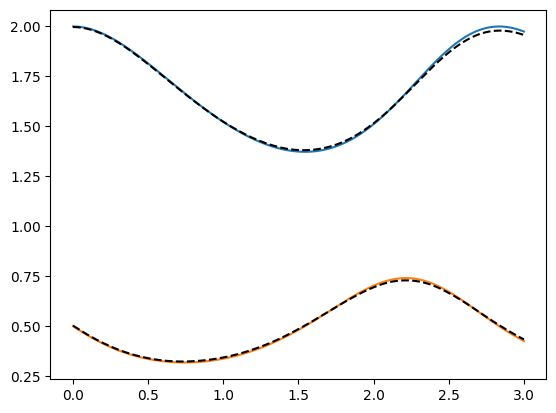

In [17]:
tt = torch.linspace(t0,tf,130).view(-1,1)
yh = model(tt).detach()
print(yh.shape)
plt.figure()
plt.plot(t,sol)
plt.plot(tt,yh,linestyle='--', color="black")

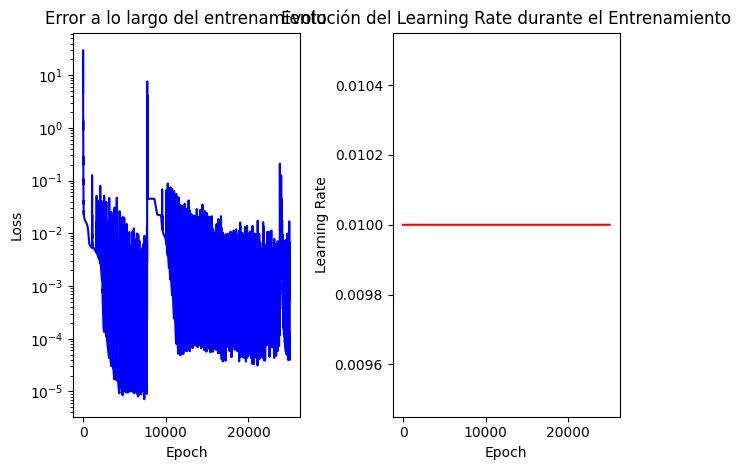

In [18]:
# Crear una figura con dos subgráficas
plt.figure()
plt.subplot(1,2,1)
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')
plt.subplot(1,2,2)
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate durante el Entrenamiento')


# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()